# <Center>Item Based Recommender System

In [1]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
from IPython.display import Image, display, HTML

import warnings
warnings.filterwarnings("ignore")

## In this notebook, we are going to build an item-based collaborative filtering using K-Nearest Neighbor model and apply Cosine Similarity and Adjusted Cosine Similarity for item similarity computation. Additionally, we compute RMSE of both methods to see which approach has a better performance.

## Exploratory Data Analysis (EDA)

In [2]:
#Load the data
books = pd.read_csv('data/BX-Books.csv', sep=';', encoding="latin-1", on_bad_lines='skip')

users = pd.read_csv('data/BX-Users.csv', sep=';', encoding="latin-1", on_bad_lines='skip')

ratings = pd.read_csv('data/BX-Book-Ratings.csv', sep=';', encoding="latin-1", on_bad_lines='skip')

In [3]:
# Change name of attributes
books.columns = ['ISBN', 'BookTitle', 'BookAuthor', 'YearOfPublication', 'Publisher', 'ImageUrlS', 'ImageUrlM', 'ImageUrlL']
users.columns = ['UserID', 'Location', 'Age']
ratings.columns = ['UserID', 'ISBN', 'BookRating']

Insight of book.csv

In [4]:
(books.isnull() | books.empty | books.isna()).sum()

ISBN                 0
BookTitle            0
BookAuthor           2
YearOfPublication    0
Publisher            2
ImageUrlS            0
ImageUrlM            0
ImageUrlL            3
dtype: int64

In [5]:
books.head(10)

,ISBN,BookTitle,BookAuthor,YearOfPublication,Publisher,ImageUrlS,ImageUrlM,ImageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...
7,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...
8,0679425608,Under the Black Flag: The Romance and the Real...,David Cordingly,1996,Random House,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...,http://images.amazon.com/images/P/0679425608.0...
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...


In [6]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ISBN               271360 non-null  object
 1   BookTitle          271360 non-null  object
 2   BookAuthor         271358 non-null  object
 3   YearOfPublication  271360 non-null  object
 4   Publisher          271358 non-null  object
 5   ImageUrlS          271360 non-null  object
 6   ImageUrlM          271360 non-null  object
 7   ImageUrlL          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


#### How many books did we get?

In [7]:
books.shape

(271360, 8)

Insight of ratings.csv

In [8]:
(ratings.isnull() | ratings.empty | ratings.isna()).sum()

UserID        0
ISBN          0
BookRating    0
dtype: int64

In [9]:
ratings.head(10)

,UserID,ISBN,BookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
5,276733,2080674722,0
6,276736,3257224281,8
7,276737,0600570967,6
8,276744,038550120X,7
9,276745,342310538,10


In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   UserID      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   BookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


#### How many ratings did we get?

In [11]:
ratings.shape

(1149780, 3)

#### Let's plot the rating distribution

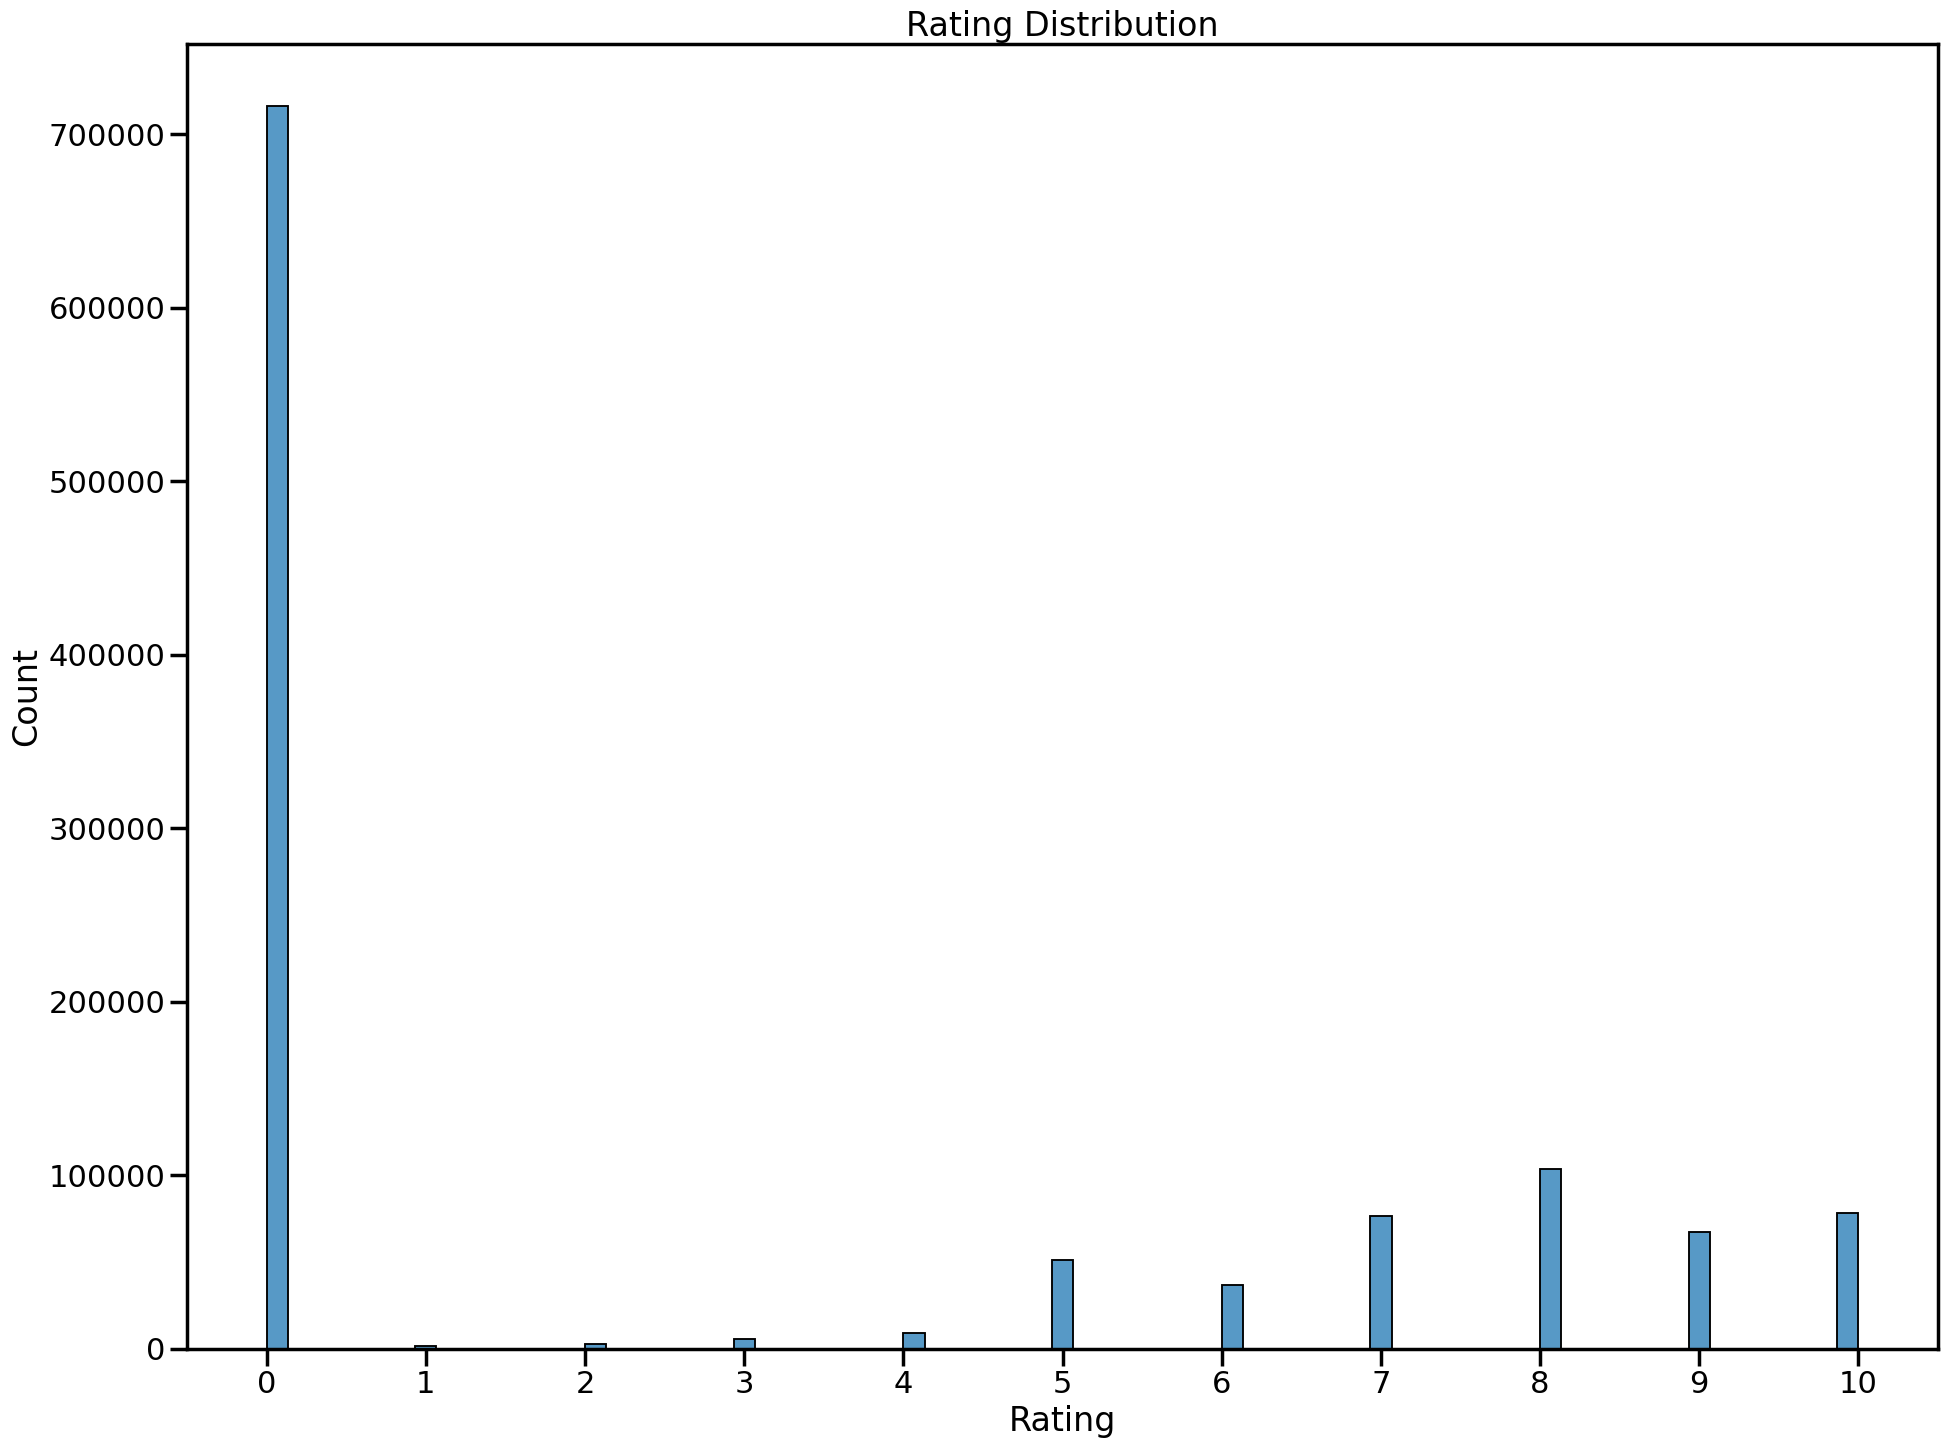

In [12]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
sns.histplot(ratings['BookRating'])
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(0, 11))
plt.tight_layout()
plt.show()

We can see that most of ratings are 0. One possible explanation is that user-item interactions have not occurred or have not been recorded. This might be a problem since it will enlarge the sparsity of dataset.

In [13]:
(users.isnull() | users.empty | users.isna()).sum()

UserID           0
Location         0
Age         110762
dtype: int64

#### Find out user's age distribution with histogram

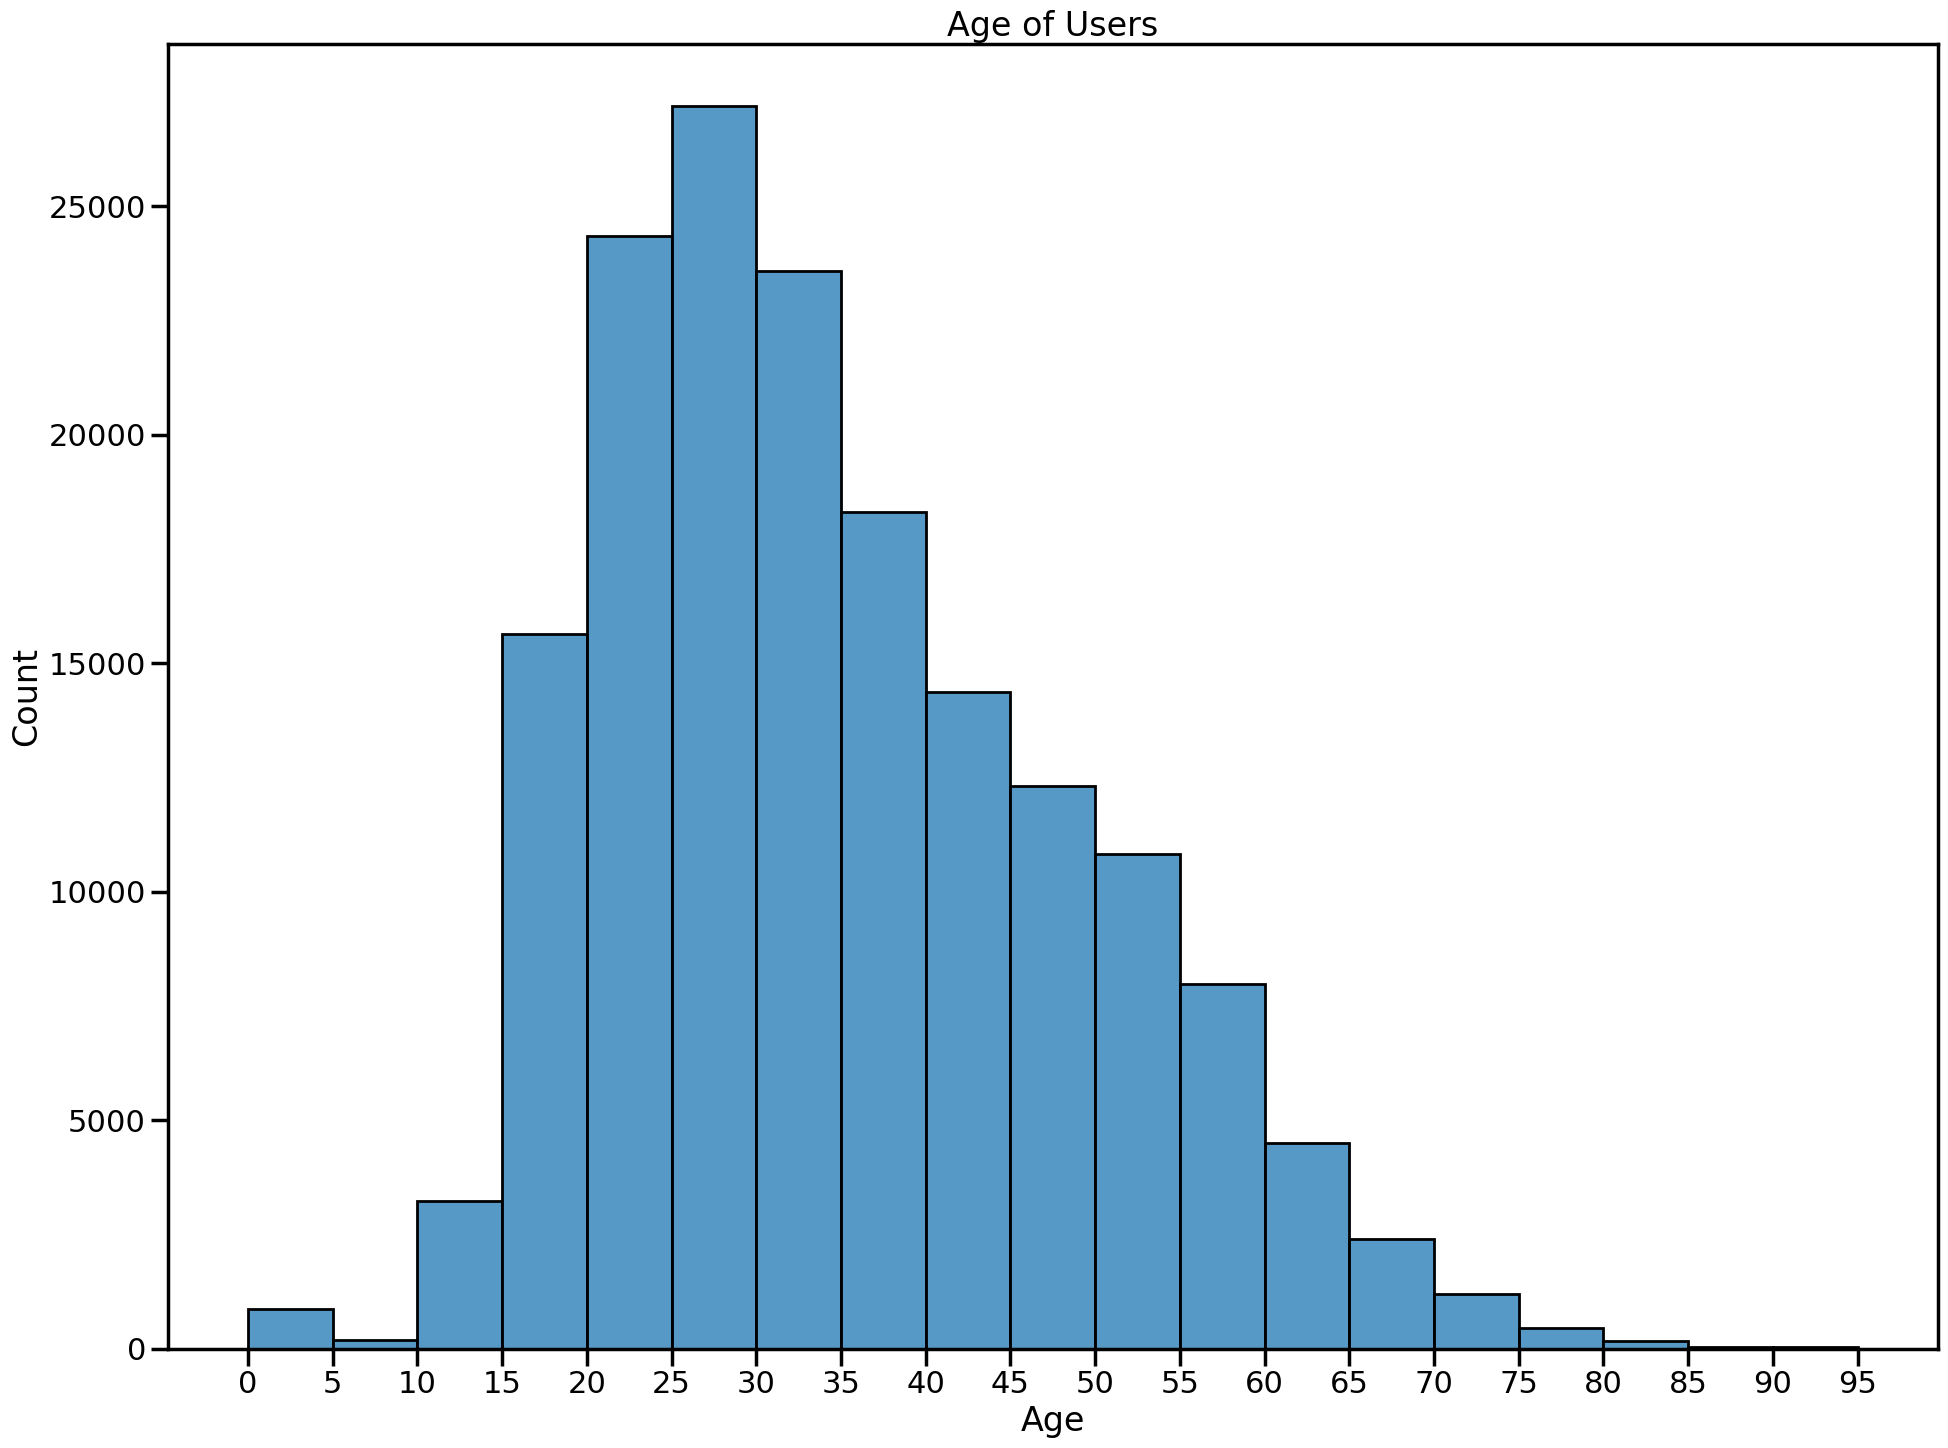

In [14]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
sns.histplot(users.Age, bins=list(range(0, 100, 5)))
plt.xticks(range(0, 100, 5))
plt.title("Age of Users")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### How many user are there?

In [15]:
len(ratings['UserID'].unique())

105283

#### Let's filter out the users with less than 50 reviews and the books with less than 50 ratings.

In [16]:
# Filter out the users with less than 50 reviews
ratings_count = ratings.groupby('UserID')['ISBN'].count()
active_users_id = ratings_count[ratings_count > 50].index.tolist()
active_users = ratings[ratings['UserID'].isin(active_users_id)]
active_users

,UserID,ISBN,BookRating
173,276847,0446364193,0
174,276847,3257200552,5
175,276847,3379015180,0
176,276847,3404145909,8
177,276847,3404148576,8
...,...,...,...
1149744,276688,0836236688,10
1149745,276688,0892966548,10
1149746,276688,1551669315,6
1149747,276688,1575660792,7


In [17]:
#Filter out the books with less than 50 ratings
item_ratings_count=active_users.groupby('ISBN')['UserID'].count()
popular_items_id = item_ratings_count[item_ratings_count > 50].index.tolist()
popular_ratings = active_users[active_users['ISBN'].isin(popular_items_id)]
popular_ratings

,UserID,ISBN,BookRating
173,276847,0446364193,0
413,276925,002542730X,10
426,276925,0316666343,0
429,276925,0385504209,8
453,276925,0804106304,0
...,...,...,...
1149696,276688,0446604666,0
1149712,276688,0553569155,0
1149715,276688,0553575104,6
1149726,276688,0679751521,0


#### List out the top 20 rated books

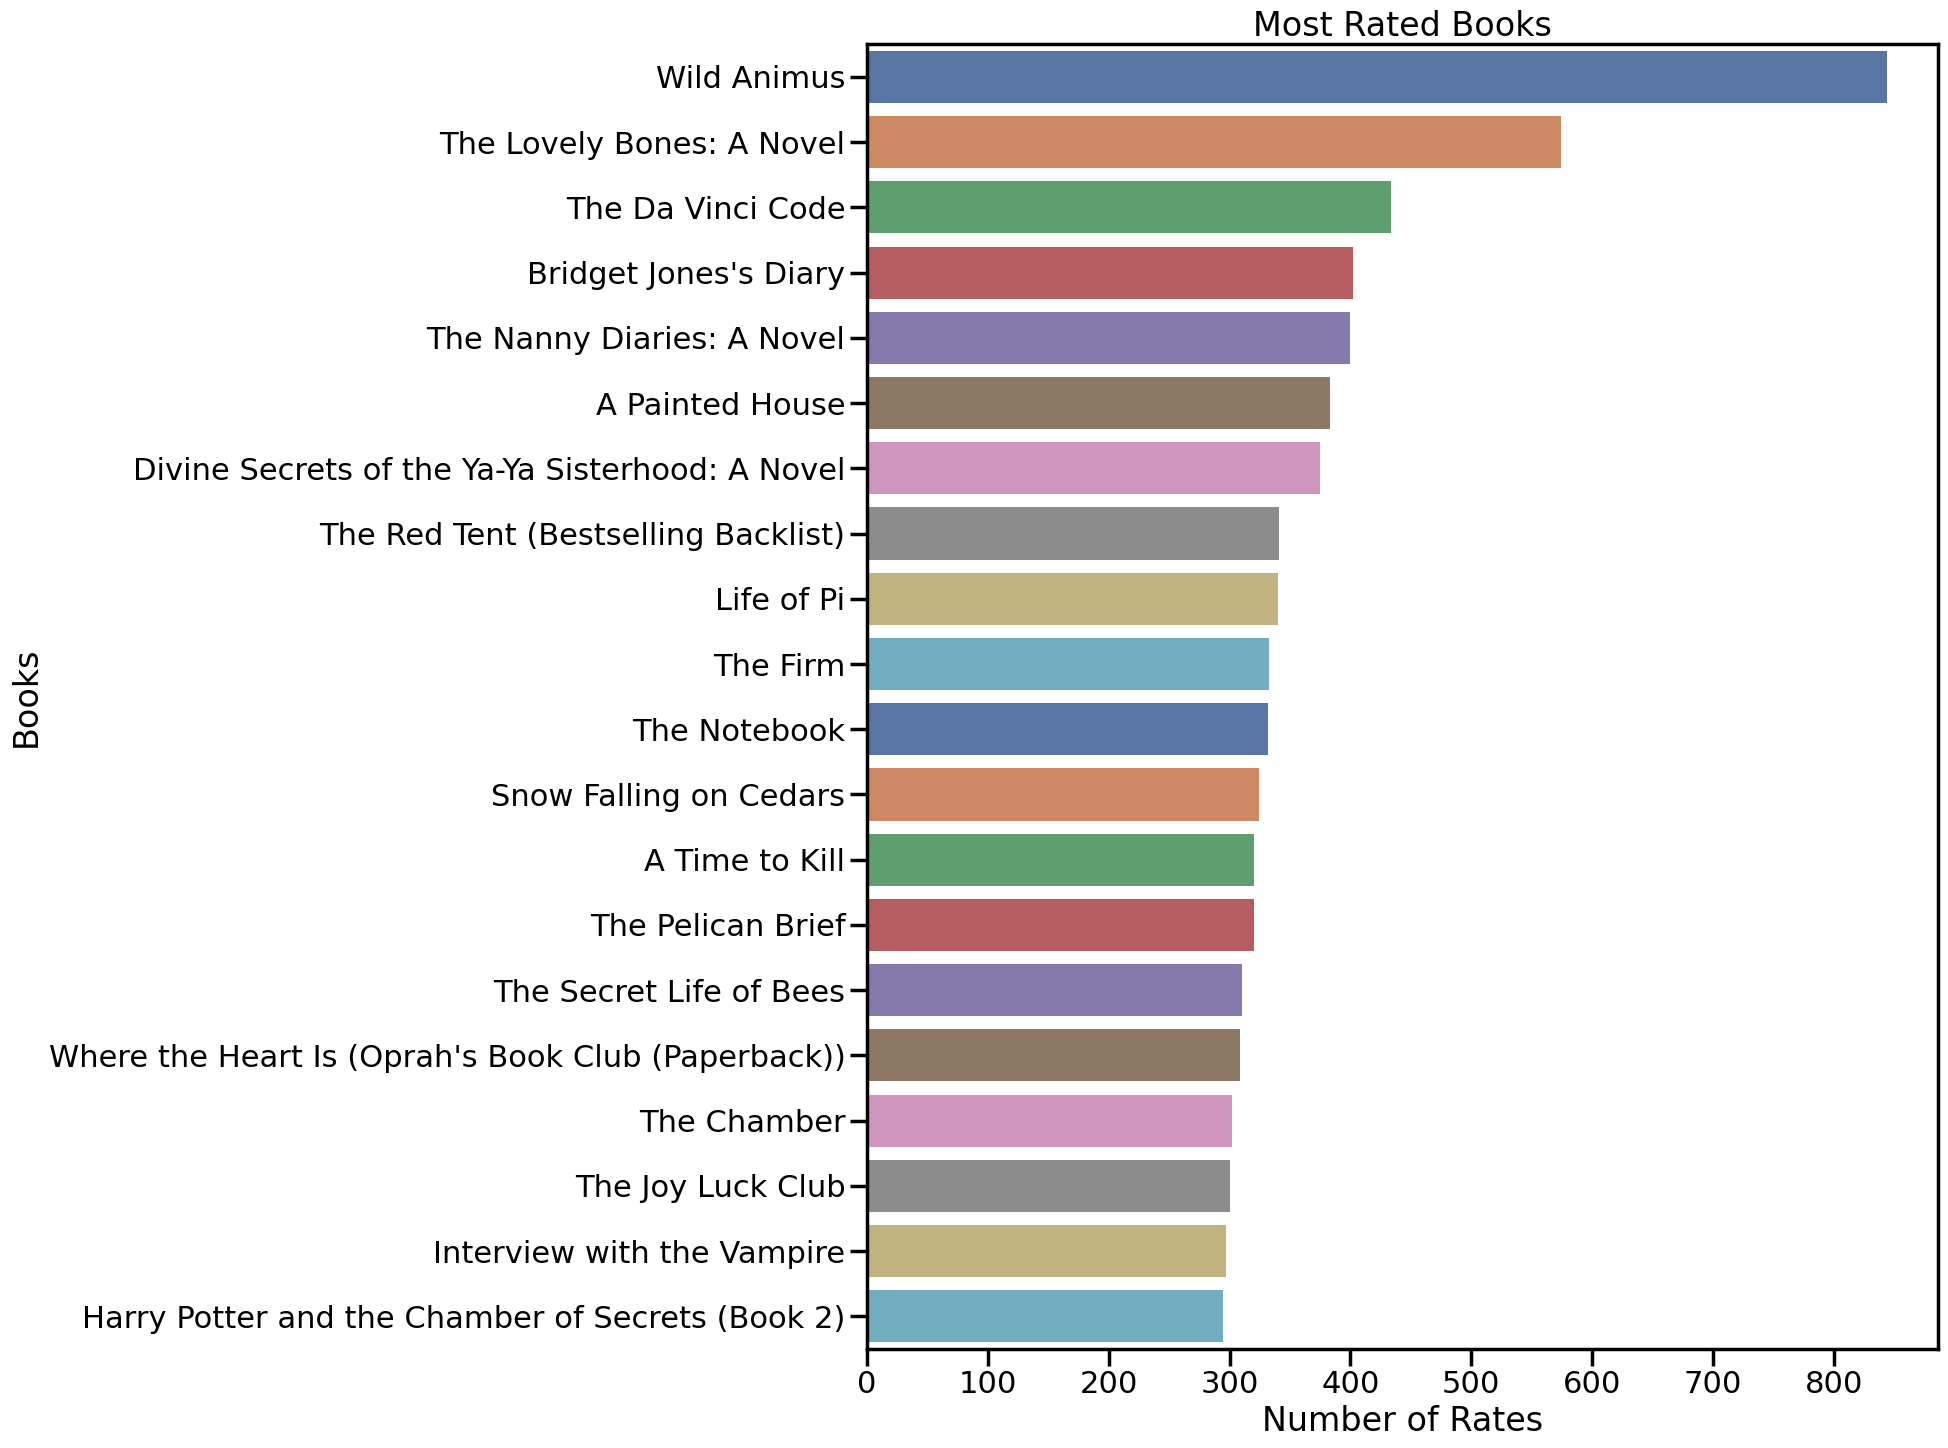

In [18]:
df= popular_ratings.merge(books, on='ISBN', how ='left')
most_rated_books = df['BookTitle'].value_counts()[:20]

sns.set_context('poster')
plt.figure(figsize=(20,15))
sns.barplot(x = most_rated_books, y = most_rated_books.index, palette='deep')
plt.title("Most Rated Books")
plt.xlabel("Number of Rates")
plt.ylabel("Books")
plt.tight_layout()
plt.show()

#### Visualize the distribution of year of publication

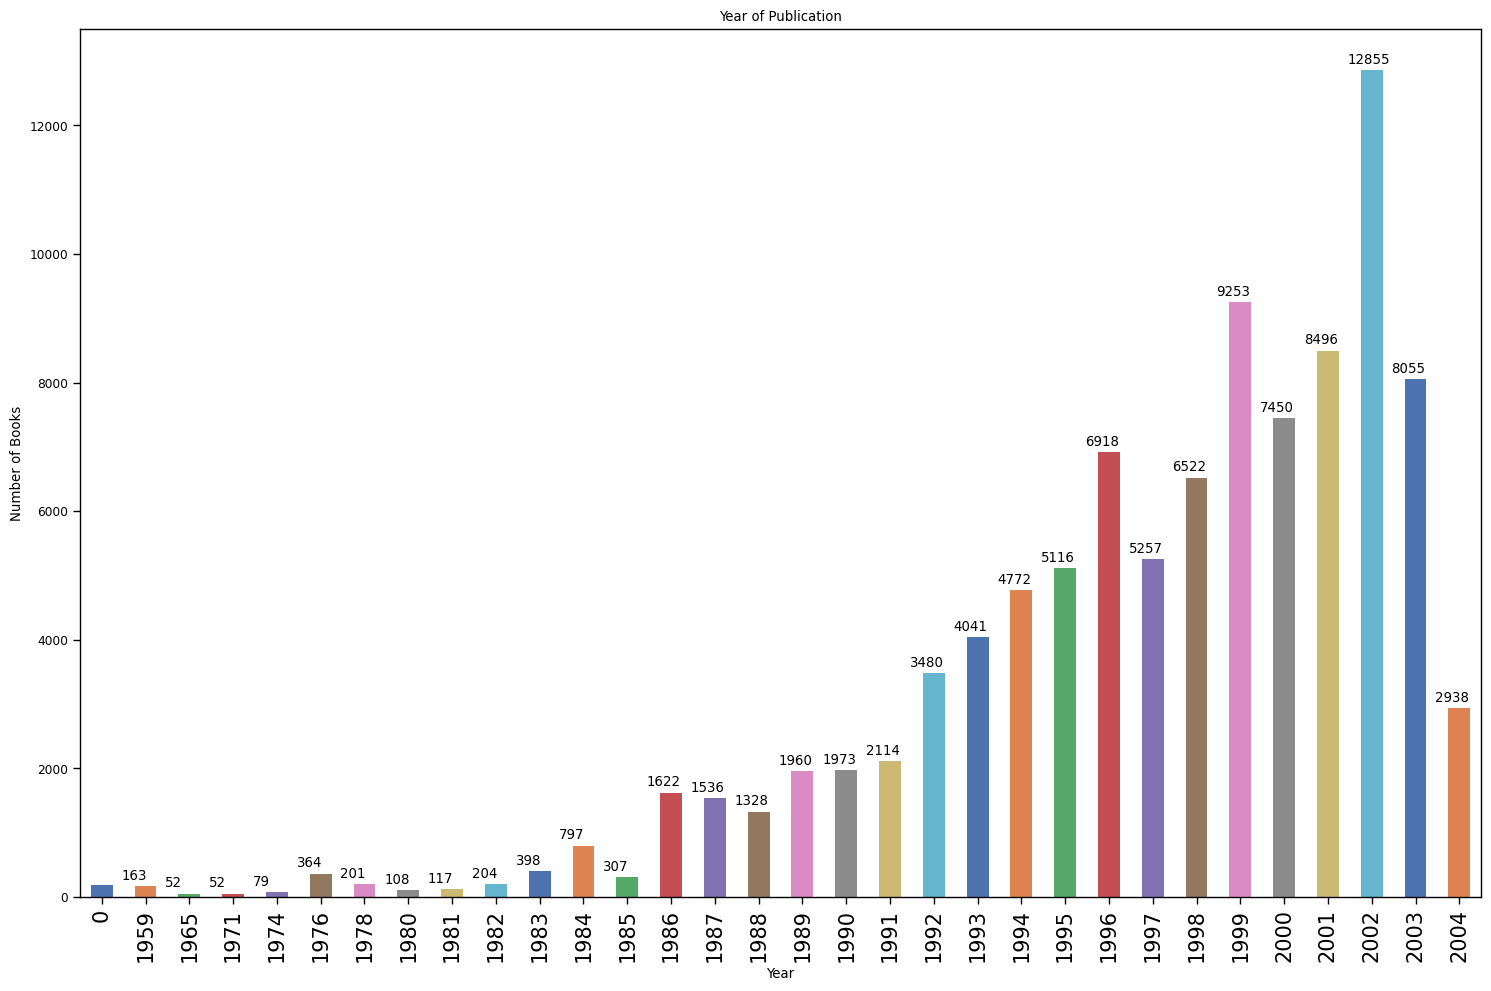

In [19]:
sns.set_context('paper')
plt.figure(figsize=(15,10))
sns_palette = sns.color_palette('deep', n_colors=len(df['YearOfPublication'].unique()))
color_list = sns_palette.as_hex()
ax = df.groupby('YearOfPublication')['BookTitle'].count().plot.bar(color=color_list)
plt.title('Year of Publication')
plt.xlabel("Year")
plt.ylabel("Number of Books")
plt.xticks(fontsize = 15)
plt.tight_layout()
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.3, p.get_height()+100))

#### Top 10 the most rated authors

In [20]:
df['BookAuthor'].value_counts().head(10)

BookAuthor
Nora Roberts          3701
Stephen King          3145
John Grisham          2901
James Patterson       2878
Sue Grafton           2117
Mary Higgins Clark    1988
Janet Evanovich       1887
Dean R. Koontz        1872
J. K. Rowling         1411
Tom Clancy            1410
Name: count, dtype: int64

## Data Preprocessing

In [21]:
#After pivot the table, most values will be Nan. Fill those values with zero.
ratings_pivot = popular_ratings.pivot(index='ISBN', columns='UserID').BookRating.fillna(0)
userID = ratings_pivot.index
ISBN = ratings_pivot.columns

print(ratings_pivot.shape)
ratings_pivot.head(15)

(1063, 3155)


UserID,243,254,507,626,638,643,741,882,929,1025,...,277928,277965,278026,278137,278144,278188,278418,278582,278633,278843
ISBN,,,,,,,,,,,,,,,,,,,,,
002026478X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002542730X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060008032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060085444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060096195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006016848X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060173289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
0060175400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006019491X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Split data into 80% of training data and 20% of testing data

In [22]:
split_ratio = 0.2
test_df = ratings_pivot.sample(round(len(ratings_pivot)*split_ratio), axis=1)
train_df = ratings_pivot.drop(test_df.columns, axis=1)

# Convert to Numpy array
test = test_df.values
train = train_df.values
print(test.shape,train.shape)

(1063, 213) (1063, 2942)


## Model Training

Cosine Similarity: $$ sim (i, j) = \frac{\sum_{u \in U} r_{ui} \cdot r_{uj}}{\sqrt{\sum_{u \in U} r_{ui}^2} \cdot \sqrt{\sum_{u \in U} r_{uj}^2}} $$



Adjusted Cosine Similarity: $$ sim(i, j) = \frac{\sum_{u \in U} (r_{u,i} - \bar{r}_u) \cdot (r_{u,j} - \bar{r}_u)}{\sqrt{\sum_{u \in U} (r_{u,i} - \bar{r}_u)^2} \cdot \sqrt{\sum_{u \in U} (r_{u,j} - \bar{r}_u)^2}} $$

Where:
- sim(i, j) is the Adjusted Cosine Similarity between items i and j.
- U is the set of all users who have rated both items i and j.
- r(u,i) is the rating of user u for item i.
- r(u,j) is the rating of user u for item j.
- r(u) is the average rating given by user u.


To deal with the variability in user rating behaviors, where some users tend to give high ratings and others prefer lower ratings, we can improve vector-based similarity measures. By subtracting each user's average rating from their ratings for a given pair of items.

#### This function calculate mean RMSE of the model by comparing the predicted ratings and the actual ratings for each items

In [23]:
def calculate_rmse(ratings, metric, k): 
    
    errors = list()
    y_true, y_pred = [],[]
    if metric == 'Adjusted_Cosine':
        # Calculate the Adjusted Cosine similarity matrix
        row_mean = ratings.mean(axis=1)
        item_mean_subtracted = ratings - row_mean[:, None]
        sim_matrix = 1 - squareform(pdist(item_mean_subtracted, 'cosine'))
    
    for item_id in range(ratings.shape[0]):
        # Get top k similar items
        if metric == 'Adjusted_Cosine':
            similarities, indices = similar_items_prediction(item_id, sim_matrix, metric, k)
        else:
            similarities, indices = similar_items_prediction(item_id, ratings, metric, k)

        # Get predicted rating and real rating
        true, pred = predict_ratings(ratings.copy(), indices, similarities)
        # Use sklearn 'mean_squared_error' to get MSE. And then we can get RMSE by calculating the square root of it
        y_true += true.tolist()
        y_pred += pred.tolist()

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#### This function calculate similarities between item with Cosine or Adjusted Cosine method.

In [24]:
def similar_items_prediction(item_id, ratings, metric, k):
    try:
        if metric=='Cosine':
            similarities=[]
            # Initiatialize the model
            model_knn = NearestNeighbors(n_neighbors=k+1, metric = 'cosine', algorithm = 'brute')
            
            # Fit the model
            model_knn.fit(ratings)
            
            # Predict the distances
            distances, indices = model_knn.kneighbors(ratings[item_id, :].reshape(1, -1), n_neighbors = k+1)
            
            # We can compute similarity by compute 1-distance
            similarities = 1-distances.flatten()
            indices   = indices.flatten()

        if metric == 'Adjusted_Cosine':

            # Sort the item with similarities
            sorted_indices = np.argsort(ratings[item_id])
            
            # Get the indices of the top 10 highest values
            top_k_indices = sorted_indices[-(k+1):]
            
            # Get the top 10 highest values
            top_k_similarities = ratings[item_id][top_k_indices]
            
            # Since np.argsort sorts in ascending order, reverse the top_10_indices and top_10_values to get highest first
            indices = top_k_indices[::-1]
            similarities = top_k_similarities[::-1]
    except:
        print("Please enter again\n")
            
    return similarities,indices

#### Once we make a model using one of the similarity measures described above, we can predict the rating for any user-item pair by using the idea of 'weighted sum'. First we take all the items similar to our target item, and from those similar items, we pick items which the active user has rated. We weight the user's rating for each of these items by the similarity between that and the target item. Finally, we scale the prediction by the sum of similarities to get a reasonable value for the predicted rating

Predict Ratings: $$P_{u,m} = \frac{\sum_{N} (s_{m,k} * R_{u,k})}{\sum_{N} (\|s_{m,k}\|)}$$

- Where Pu,m is the prediction of item m for user u.
- Ru,k is the rating from user u on item k.
- N is a set of similar items.
- k is an element of N.
- sm,k is the similarity value between two items.

#### For Example:
![Predict Ratings.png](Predict_Ratings.png)

In [25]:
def predict_ratings(ratings, indices, similarities):
    weighted_ratings = np.zeros(ratings.shape[1])
    # Sum up weighted ratings
    for i, index in enumerate(indices):
        weighted_ratings += ratings[index]*similarities[i]

    # Total Similarity
    sim_total=similarities.sum()
    # Predict scores
    predictions  = weighted_ratings / sim_total
    # Find the indices of rated item
    index_nonzeros_items = ratings[indices[0]].nonzero()
    
    # Actual ratings
    y_true = ratings[indices[0]][index_nonzeros_items]
    # Predicted ratings
    y_pred = np.around(predictions[index_nonzeros_items])
    return y_true, y_pred

## Evaluations

Root Mean Square Error(RMSE)
$$\mathrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

To measure the performance of the implementation, root mean square error (RMSE) was used to calculate the results and the actual ratings. The formula for RMSE is shown below. A high value of RMSE implies a less accurate prediction of the rating, whereas a low value implies a more accurate prediction in regards to the real value.

In [26]:
%%time
# Calculate RMSE of Cosine KNN model with k ranged from 1 to 20
cosine_rmse=[]
k_list = list(range(1,20))
for k in k_list:
    result = calculate_rmse(train, 'Cosine', k-1)
    cosine_rmse.append([k,result])

CPU times: total: 4min 30s
Wall time: 12min 50s


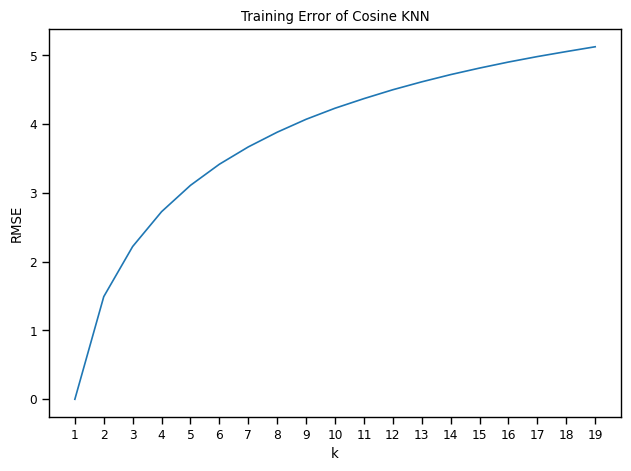

In [27]:
k_cosine_rmse_np = np.array(cosine_rmse)
plt.xticks(k_list)
plt.title('Training Error of Cosine KNN')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.plot(k_cosine_rmse_np[:, 0], k_cosine_rmse_np[:,1])
plt.tight_layout()
plt.show()

In [28]:
%%time
# Calculate RMSE of Adjusted Cosine KNN model with k ranged from 1 to 20
adjusted_cosine_rmse=[]
k_list = list(range(0,20))
for k in k_list:
    result = calculate_rmse(train, 'Adjusted_Cosine', k)
    adjusted_cosine_rmse.append([k,result])

CPU times: total: 1min 14s
Wall time: 3min 4s


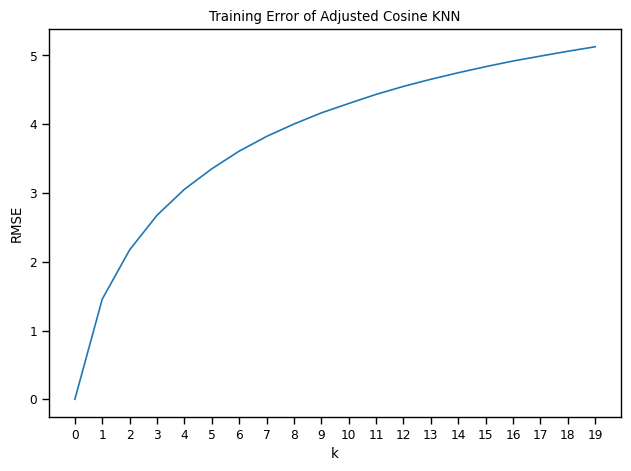

In [29]:
k_adjusted_cosine_np = np.array(adjusted_cosine_rmse)
plt.xticks(k_list)
plt.title('Training Error of Adjusted Cosine KNN')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.plot(k_adjusted_cosine_np[:, 0], k_adjusted_cosine_np[:,1])
plt.tight_layout()
plt.show()

#### From the plots above, we can observe that the training error is 0 while k=1. This is because KNN algorithm finds only 1 nearest neighbor, which is itself. Therefore, the similarity between one and itself will be 1. We can also infer that KNN model easily gets overfitting if k is low. The reason is that a lower value of k represents a more complex model because it makes the decision boundary more flexible to closely follow the training data.

### Test the model using test data

In [30]:
def test_rmse(test, ratings, test_ratio,  metric):
    number_of_users = test.shape[1]
    y_pred, y_true = [], []
    
    for user in range(number_of_users):
        # Find indices of rated item
        rated_items_by_user = np.array([i for i in range(test.shape[0]) if test[i,user]>0])
        # To prevent the case of 0 ratings to be predicted. This will lead to errors while computing RMSE
        if len(rated_items_by_user) < 3:
            continue;
        test_size = round(test_ratio * len(rated_items_by_user))
        # Randomly choose the indices of ratings that we are going to predict
        test_indices = np.random.randint(0, len(rated_items_by_user), test_size)
        withheld_items = rated_items_by_user[test_indices]

        mask = np.ones(len(rated_items_by_user), dtype=bool)
        mask[test_indices] = False
        not_withheld_items = rated_items_by_user[mask]

        weighted_sum = 0
        sim_total = 0
        # Compute root mean square error for user over all test items
        for pred_item in withheld_items:
            for item in not_withheld_items:
                # Estimate distance with selected metric
                if metric=='Cosine':
                    distance = cosine_Similarity(ratings[item], ratings[pred_item])

                if metric == 'Adjusted_Cosine':
                    distance = ratings[item,pred_item]

                # Sum up weighted ratings
                weighted_sum += (1-distance)*test[item, user]
                # Total similarities
                sim_total += 1-distance

            y_pred.append(weighted_sum/sim_total)
        y_true += test[withheld_items, user].tolist()

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
    return rmse

In [31]:
# Cosine Similarity
def cosine_Similarity(A,B):
    distance = np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))   
    return distance

In [38]:
# Calculate root mean square error using cosine similarity
rmse = test_rmse(test, train, 0.2,  'Cosine')
print('RMSE of Cosine Similarity:',rmse)

RMSE of Cosine Similarity: 1.6094812450596627


In [39]:
# Create similarity matrix
row_mean = train.mean(axis=1)
item_mean_subtracted = train - row_mean[:, None]
sim_matrix = 1 - squareform(pdist(item_mean_subtracted, 'cosine'))

# Calculate root mean square error using adjusted cosine similarity
rmse = test_rmse(test, sim_matrix, 0.2,  'Adjusted_Cosine')
print('RMSE of Adjusted Cosine Similarity:',rmse)

RMSE of Adjusted Cosine Similarity: 1.5365243251500595


Using standard cosine similarity cannot address the problem that different users might have different baselines when rating items. Adjusted cosine similarity, on the other hand, attempts to normalize for this bias by subtracting the user's average rating from each of their ratings before computing similarities. This can lead to more accurate similarity measures between items, as seen in the lower RMSE.

## Recommendation books with item-based collaborative filtering

In [34]:
#Add information of books back to the dataframe
books_info = ratings_pivot.merge(books, on='ISBN', how ='left').drop(['ImageUrlM', 'ImageUrlS'], axis=1)

#### This function takes query book's title and give you top k recommendations

In [35]:
def get_recommendations(book_title, books_info, metric, k):
    item_index = books_info.index[books_info['BookTitle'].apply(lambda x: str(x).lower()) == book_title.lower()
]
    try:
        if metric == 'Cosine':
            ratings = books_info.drop(['BookTitle','ImageUrlL','ISBN', 'BookAuthor', 'YearOfPublication', 'Publisher'], axis = 1).values
            
            similarities, indices = similar_items_prediction(item_index[0], ratings, 'cosine', k)

       
        if metric == 'Adjusted_Cosine':
            # Calculate the Adjusted Cosine similarity matrix
            ratings = books_info.drop(['BookTitle','ImageUrlL','ISBN', 'BookAuthor', 'YearOfPublication', 'Publisher'], axis = 1).values
            row_mean = ratings.mean(axis=1)
            item_mean_subtracted = ratings - row_mean[:, None]
            sim_matrix = 1 - squareform(pdist(item_mean_subtracted, 'cosine'))
            
            similarities, indices = similar_items_prediction(item_index[0], sim_matrix, metric, k)
        else:
            print("Please enter Metric Again\n")
        
        display_recommends(books_info, indices, k) 
    except:
        print("Please enter Book Title Again\n")

In [36]:
def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'        

def display_recommends(books_info, indices, k):      
    BookTitle, ImageURL, Author, Years, Publisher = [], [], [], [], []
    print('Top {0} most similar books for \'{1}\':\n'.format(k,books_info['BookTitle'].iloc[indices[0]]))
    for i in range(1, len(indices.flatten())):
            BookTitle.append(books_info['BookTitle'].iloc[indices[i]])
            ImageURL.append(books_info['ImageUrlL'].iloc[indices[i]])
            Author.append(books_info['BookAuthor'].iloc[indices[i]])
            Years.append(books_info['YearOfPublication'].iloc[indices[i]])
            Publisher.append(books_info['Publisher'].iloc[indices[i]])
    
    recommend_df=pd.DataFrame([BookTitle,Author, Years, Publisher, ImageURL]).T
    recommend_df.columns=['Book Name', 'Author','Year of Publication','Publisher','Book Cover', ]
    image_cols = ['Book Cover']
    format_dict = {}
    for image_col in image_cols:
        format_dict[image_col] = path_to_image_html
    
    # Display top k books and its information in dataframe
    display(HTML(recommend_df.to_html(escape=False ,formatters=format_dict)))

In [37]:
get_recommendations('Touching Evil', books_info, 'Adjusted_Cosine', 10)

Top 10 most similar books for 'Touching Evil':



,Book Name,Author,Year of Publication,Publisher,Book Cover
0,"Forever... : A Novel of Good and Evil, Love and Hope",Jude Deveraux,2002,Pocket,
1,"Whisper of Evil (Hooper, Kay. Evil Trilogy.)",Kay Hooper,2002,Bantam Books,
2,Purity in Death,J.D. Robb,2002,Berkley Publishing Group,
3,The Jester,James Patterson,2003,"Little, Brown",
4,Small Town Girl,Lavyrle Spencer,1998,Jove Books,
5,True Blue,Luanne Rice,2002,Bantam Books,
6,"Key of Valor (Roberts, Nora. Key Trilogy, 3.)",Nora Roberts,2003,Jove Pubns,
7,Now You See Me,Tina Wainscott,2002,St. Martin's Paperbacks,
8,Reunion in Death,J. D. Robb,2002,Berkley Publishing Group,
9,Getting Rid Of Bradley,Jennifer Crusie,2001,Mira,


## Conclusions

Although we get a quite acceptable RMSE on test data, there still exists plenty of ways to improve the recommendation system. One potential method is to address the significant sparsity of our dataset. Using Singular Value Decomposition(SVD) might be a solution for this problem. SVD often provides high accuracy in predictions by capturing the underlying structure of the data. We can not only extract underlying key features but also reduce the noise from the data.

Another way to improve item-based collaborative filtering is to add metadata to our dataset. Instead of a singular rating, having diverse ratings for an item allows us to get more information on the similarity between items. For instance, a user rating for 'Harry Potter' as {'fantasy':10, 'love': 8, 'sci-fi': 0} allows us to predict ratings more accurately across different genres. Such an approach could significantly boost the performance.

## Thank you for reading